     position  score
0           1 -1.040
1           2 -1.126
2           3 -0.693
3           4 -1.177
4           5 -0.980
..        ...    ...
209       210 -0.641
210       211 -0.505
211       212  0.820
212       213 -0.796
213       214 -1.345

[214 rows x 2 columns]


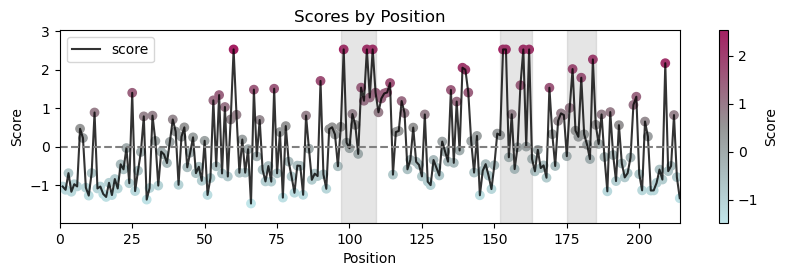

     position  score
0           1  0.000
1           2  0.000
2           3 -0.110
3           4  0.393
4           5  0.188
..        ...    ...
98         99  0.000
99        100  0.000
100       101  0.000
101       102  0.000
102       103  0.000

[103 rows x 2 columns]


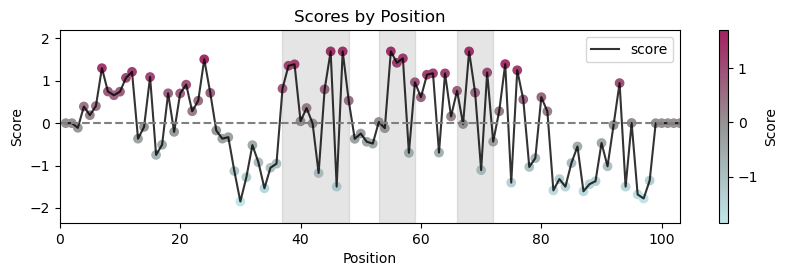

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

def plot_conservation(df, defattr_file, windows=[]):
    max_score = df['score'].max()
    min_score = df['score'].min()
    
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Create a colormap using the cayenne-maroon color palette
    cmap = mcolors.LinearSegmentedColormap.from_list('cayenne-maroon', ['#c1e6ea', '#969696','#a42062'])
    
    df.plot(x='position', y='score', ax=ax, color='black', alpha=0.8)

    ax.scatter(df['position'], df['score'], c=df['score'], cmap=cmap)
    # alpha=abs(df['score'])/max_score
    
    ax.set_title('Scores by Position')
    ax.set_xlabel('Position')
    ax.set_xlim(0, len(df['position']))
    ax.set_ylabel('Score')
    ax.set_ylim(min_score - 0.5, max_score + 0.5)
    ax.axhline(y=0, color='grey', linestyle='--')

    # Add a colorbar to show the mapping between y value (score) and color
    cbar = fig.colorbar(ax.collections[0])
    cbar.ax.set_ylabel('Score')
    if windows != []:
        for window in windows:
            upper = int(window.split('-')[0])
            lower = int(window.split('-')[1])
            ax.axvspan(upper, lower, alpha=0.2, color='grey')
    plt.savefig(f"{defattr_file}.svg", format="svg")
    plt.show()
    return plt 


def convert_plot_conservation(defattr_file, windows=[]):
    with open(defattr_file) as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        lines = [x.split('\t') for x in lines]
        lines = lines[3:]
        df = pd.DataFrame(lines)
        df.columns = ['position', 'score']
        df['position'] = df['position'].apply(lambda x: int(x.split(':')[1]) if x is not None else 0)
        df['score'] = df['score'].apply(lambda x: float(x) if x != 'None' else 0)
        print(df)
        plot = plot_conservation(df, defattr_file, windows=windows)

        return df

defattr_file1 = 'chimerax_out/sir_0168_seq_cons_attr.defattr'
defattr_file2 = 'chimerax_out/GC1825_seq_cons_attr.defattr'
ddf1 = convert_plot_conservation(defattr_file1, windows=['97-109', '152-163', '175-185'])
ddf2 = convert_plot_conservation(defattr_file2, windows=['37-48', '53-59','66-72'])

# Try a distance map 
code from https://warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/protein_contact_map/

In [117]:
import Bio.PDB
import numpy

sir_0168_pdb = 'pdb_files/sir_0168 monomer.pdb'
gc_pdb = 'pdb_files/GC1825_monomer.pdb'

sir_structure = Bio.PDB.PDBParser().get_structure("sir_0168", sir_0168_pdb)
sir_model = sir_structure[0]
sir_chain = sir_model['B']
sir_residue = sir_chain[10]
sir_atom = sir_residue['CA']

gc_structure = Bio.PDB.PDBParser().get_structure("GC1825", gc_pdb)
gc_model = gc_structure[0]

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
   
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return numpy.sqrt(numpy.sum(diff_vector * diff_vector))

def fix_chain(chain):
    for residue in chain:
        if residue.id[0] != ' ':
            chain.detach_child(residue.id)
            
    return chain

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    chain_one = fix_chain(chain_one)
    chain_two = fix_chain(chain_two)
    
    answer = numpy.zeros((len(chain_one), len(chain_two)), numpy.float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

sir_dist_matrix = calc_dist_matrix(sir_model['B'], sir_model['B'])
sir_contact_map = sir_dist_matrix < 12



/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_7614/2646664288.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  answer = numpy.zeros((len(chain_one), len(chain_two)), numpy.float)


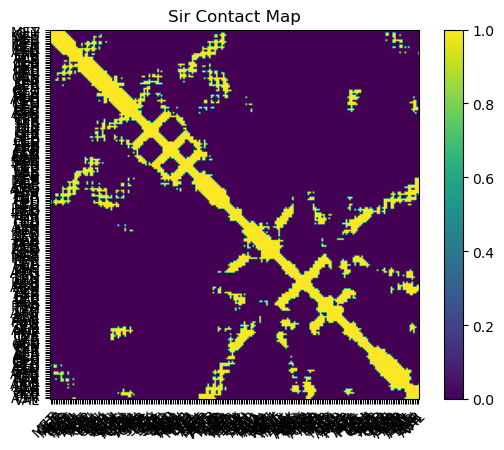

In [118]:
import matplotlib.pyplot as plt

# c = ddf1['score'].tolist()

fig, ax = plt.subplots()
im = ax.imshow(sir_contact_map, cmap='viridis')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# x = [residue.id[1] for residue in sir_chain]
# y = [residue.id[1] for residue in sir_chain]
# c = ddf1['score'].tolist()
# ax.scatter(x, y, c=c, cmap='viridis')

# Set axis labels
ax.set_xticks(numpy.arange(len(sir_chain)))
ax.set_yticks(numpy.arange(len(sir_chain)))
ax.set_xticklabels([residue.resname for residue in sir_chain])
ax.set_yticklabels([residue.resname for residue in sir_chain])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set plot title
ax.set_title("Sir Contact Map")

# Show the plot
plt.show()